# Fraud Detection with XGBoost
_**Using Gradient Boosted Trees to detect fraud activities**_

---

---

### Setup
_이 노트북은 ml.m5.4xlarge 에서 만들어지고 실행되었습니다._

In [10]:
%%time
import sagemaker
from sagemaker import get_execution_role


role = get_execution_role()

CPU times: user 89.9 ms, sys: 5.16 ms, total: 95.1 ms
Wall time: 214 ms


In [11]:
import boto3
import os
role

'arn:aws:iam::431487025666:role/mod-6297809195fe4845-SageMakerExecutionRole-1D0MT94A5WK9V'

In [12]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1")
container

'306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:1'

#### XGBoost는 무엇일까요?

XGBoost (익스트림 그래디언트 부스팅) 는 그라데이션 부스트 트리 알고리즘의 인기 있고 효율적인 오픈 소스 알고리즘입니다. 기울기 부스팅 (Gradient boosting) 은 더 단순하고 약한 모델 집합의 추정치를 결합하여 목표 변수를 정확하게 예측하려고 시도하는 기계 학습 알고리즘입니다. 확장성이 뛰어난 방식으로 의사 결정 트리 모델에 그라디언트 부스팅을 적용함으로써 XGBoost는 다양한 기계 학습 경쟁에서 현저하게 뛰어난 성능을 보여줍니다. 또한, 다양한 데이터 유형, 관계 및 분포를 강력하게 처리합니다. XGBoost는 모델 성능을 향상시키기 위해 조정할 수 있는 변수인 많은 하이퍼파라미터를 제공합니다. 이러한 유연성 덕분에 XGBoost는 다양한 기계 학습 문제를 해결할 수 있는 확실한 선택입니다.

#### XGBoost로 해결되는 문제 및 사용 사례

XGBoost가 가장 일반적으로 해결하는 세 가지 문제는 분류, 회귀 및 랭킹입니다.

##### 분류

분류의 목표는 입력 값을 가져와 둘 이상의 범주로 구성하는 것입니다. 분류 사용 사례의 예로는 Fraud Detector 가 있습니다. Fraud Detector 의 목표는 거래에 대한 정보를 가져와 거래가 사기인지 사기인지 아닌지를 판단하는 데 사용하는 것입니다. XGBoost에 과거 트랜잭션의 데이터 세트가 제공되고 사기인지 여부는 입력 트랜잭션 데이터를 트랜잭션이 사기성 확률에 매핑하는 함수를 배울 수 있습니다.

#### 회귀

회귀 분석에서는 입력값을 개별 개수의 클래스에 매핑하는 대신 숫자를 출력하는 것이 목표입니다. 회귀 문제의 예로는 주택이 판매될 가격을 예측하는 것입니다. 이 경우 XGBoost에 주택 및 판매 가격에 대한 과거 데이터가 제공되면 주택에 대한 해당 메타 데이터를 통해 주택의 판매 가격을 예측하는 함수를 배울 수 있습니다.

#### 랭킹 

쿼리와 문서 세트가 제공된다고 가정합니다. 랭킹에서의 목표는 문서의 상대적 중요도를 찾고 관련성에 따라 순서를 지정하는 것입니다. 랭킹의 사용 사례는 전자 상거래 웹 사이트에 대한 제품 검색입니다. 검색 결과, 클릭 수 및 성공적인 구매에 대한 데이터를 활용한 다음 학습에 XGBoost를 적용할 수 있습니다.이렇게 하면 검색된 제품에 대한 관련성 점수를 제공하는 모델이 생성됩니다.



_참조: https://aws.amazon.com/ko/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/_


_https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html_

#### Data Bucket 설정

In [13]:
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'afd/xgboost'
raw_prefix = 'afd/raw'

### Data check and set up

데이터가 다운로드 받아지고 adTalking 이라는 폴더에 저장되어 있어야 하위 셀이 실행될 수 있습니다.

In [14]:
import pandas as pd

In [15]:
%%time
file = 'train.csv'
data_folder = '../../../../data/AdTalking'

file_path = os.path.join(data_folder, file)

df = pd.read_csv(file_path, parse_dates=['click_time'])
df

CPU times: user 1min 42s, sys: 14.2 s, total: 1min 56s
Wall time: 1min 56s


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
...,...,...,...,...,...,...,...,...
184903885,121312,12,1,10,340,2017-11-09 16:00:00,NaN,0
184903886,46894,3,1,19,211,2017-11-09 16:00:00,NaN,0
184903887,320126,1,1,13,274,2017-11-09 16:00:00,NaN,0
184903888,189286,12,1,37,259,2017-11-09 16:00:00,NaN,0


In [16]:
def drop_column(raw_df, col):
    df = raw_df.drop(columns=[col])
    return df

df = drop_column(df, col='attributed_time')

In [17]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [18]:
df = df.rename(columns={'is_attributed':'EVENT_LABEL'})    
df = df.rename(columns={'click_time':'EVENT_TIMESTAMP'})

In [19]:
print("min time: ", df.EVENT_TIMESTAMP.min())
print("max time: ", df.EVENT_TIMESTAMP.max())

min time:  2017-11-06 14:32:21
max time:  2017-11-09 16:00:00


In [35]:
def split_data_by_time(df, target_col, label_col, total_samples, split_rate, train_end, test_start, verbose=False):
    '''
    시간 관점으로 번반부튼 훈련, 후반부는 테스트 데이터로 해서 샘블링 함.
    '''
    
    # 훈련 데이터 셋
    train_df = df[df[target_col] <= train_end]   
    train_num = int(total_samples * (1 - split_rate))    # 훈련 샘플 데이터 수
    train_sample = train_df.sample(n = train_num, random_state=100)    # 샘플링    

    print("train sample shape: ", train_sample.shape)
    print("train min time: ", train_sample[target_col].min())
    print("train max time: ", train_sample[target_col].max())
    print("Train fraud ratio: ", round(train_sample[label_col].value_counts()[1] / train_sample.shape[0],5))
    print("# of Train frauds: ", train_sample[label_col].value_counts()[1])     


    # 테스트 데이터 셋    
    test_df = df[df[target_col] >= test_start]    
    test_num = int(total_samples * (split_rate))    # 테스트 샘플 데이터 수
    test_sample = test_df.sample(n = test_num, random_state=100)    
    

    print("\ntest sample shape: ", test_sample.shape)    
    print("test min time: ", test_sample[target_col].min())
    print("test max time: ", test_sample[target_col].max())
    print("Test fraud ratio: ", round(test_sample[label_col].value_counts()[1] / test_sample.shape[0],5))    
    print("# of test frauds: ", test_sample[label_col].value_counts()[1])         
    
    
    return train_sample, test_sample
    
train_df, test_df = split_data_by_time(
                       df=df, 
                       target_col='EVENT_TIMESTAMP', 
                       label_col = 'EVENT_LABEL',
                       total_samples=200000, 
                       split_rate=0.1, 
                       train_end='2017-11-08 23:59', 
                       test_start='2017-11-09 00:00',    
                       verbose = True,
                  )    

train sample shape:  (180000, 7)
train min time:  2017-11-06 15:08:24
train max time:  2017-11-08 23:58:58
Train fraud ratio:  0.00242
# of Train frauds:  435

test sample shape:  (20000, 7)
test min time:  2017-11-09 00:00:01
test max time:  2017-11-09 15:59:58
Test fraud ratio:  0.00275
# of test frauds:  55


In [36]:
train_df.head()

,ip,app,device,os,channel,EVENT_TIMESTAMP,EVENT_LABEL
37517593,62184,13,1,19,477,2017-11-07 08:48:38,0
35544931,117038,11,1,19,173,2017-11-07 08:05:49,0
75642661,111102,27,1,13,153,2017-11-08 02:02:42,0
47714028,118315,3,1,19,205,2017-11-07 12:05:08,0
26703479,42280,32,1,13,376,2017-11-07 05:08:52,0


In [37]:
train = drop_column(train_df, col='EVENT_TIMESTAMP')

In [38]:
train.head()

,ip,app,device,os,channel,EVENT_LABEL
37517593,62184,13,1,19,477,0
35544931,117038,11,1,19,173,0
75642661,111102,27,1,13,153,0
47714028,118315,3,1,19,205,0
26703479,42280,32,1,13,376,0


,ip,app,device,os,channel,EVENT_LABEL
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,89068.484978,12.231356,25.180028,23.277228,270.169789,0.002417
std,64008.933142,15.357127,276.414883,57.463184,128.402379,0.049100
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40400.000000,3.000000,1.000000,13.000000,145.000000,0.000000
50%,79881.000000,12.000000,1.000000,18.000000,259.000000,0.000000
75%,118625.000000,15.000000,1.000000,19.000000,379.000000,0.000000
max,364776.000000,556.000000,3867.000000,866.000000,497.000000,1.000000


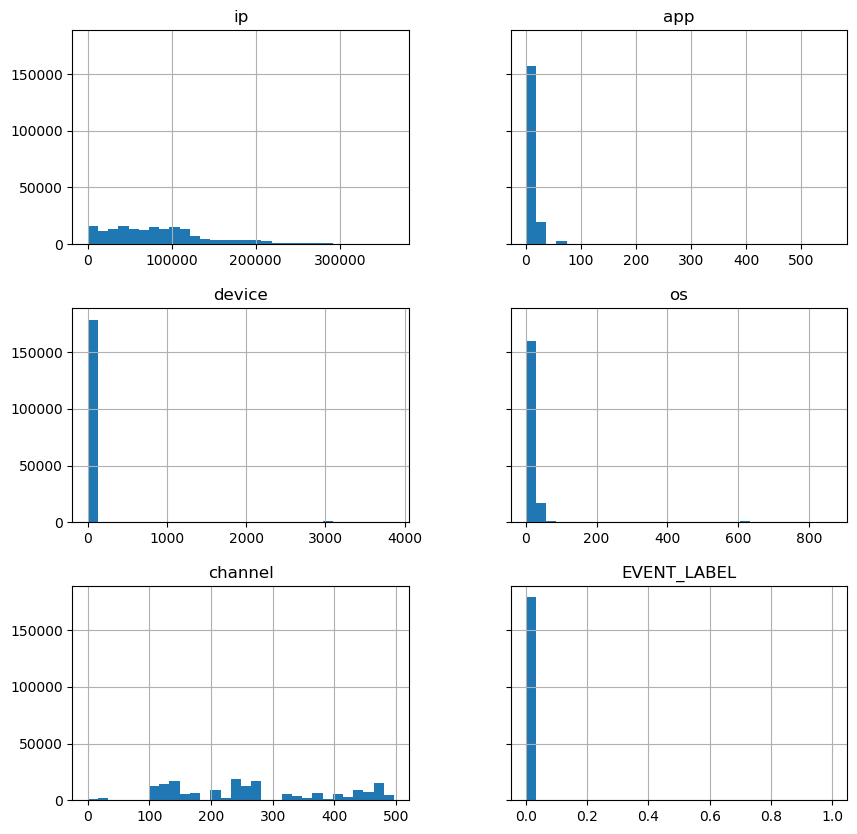

In [39]:
# Frequency tables for each categorical feature
for column in train.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=train[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(train.describe())
%matplotlib inline
hist = train.hist(bins=30, sharey=True, figsize=(10, 10))

,ip,app,device,os,channel,EVENT_LABEL
ip,1.000000,0.007629,-0.001051,0.001072,0.011203,0.043143
app,0.007629,1.000000,0.245398,0.247454,-0.026163,0.061258
device,-0.001051,0.245398,1.000000,0.951293,-0.050960,-0.000379
os,0.001072,0.247454,0.951293,1.000000,-0.048354,0.004679
channel,0.011203,-0.026163,-0.050960,-0.048354,1.000000,-0.024538
EVENT_LABEL,0.043143,0.061258,-0.000379,0.004679,-0.024538,1.000000


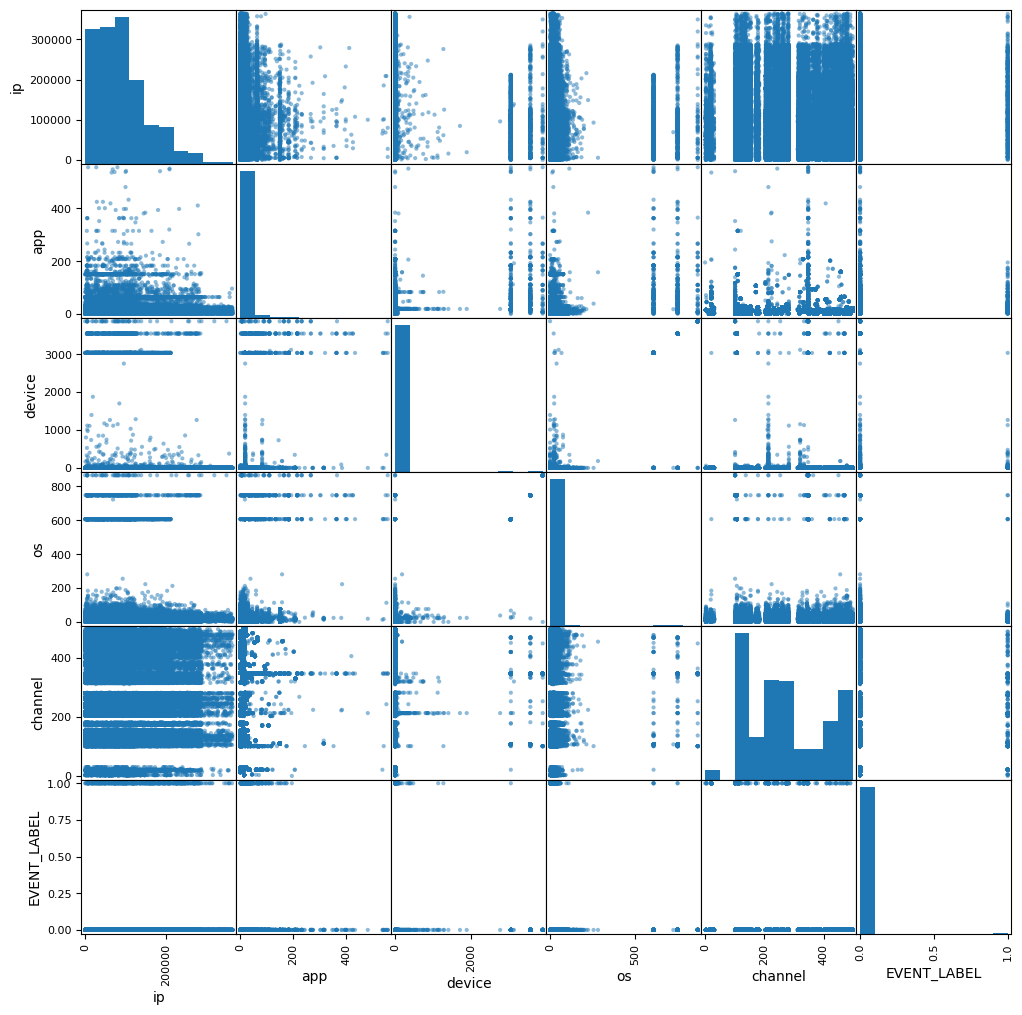

In [40]:
import matplotlib.pyplot as plt                   # For charts and visualizations
display(train.corr())
pd.plotting.scatter_matrix(train, figsize=(12, 12))
plt.show()

In [41]:
test = drop_column(test_df, col='EVENT_TIMESTAMP')

In [42]:
test.head()

,ip,app,device,os,channel,EVENT_LABEL
149521552,12461,9,1,13,244,0
175483793,108341,2,1,18,205,0
166366187,42699,12,1,19,178,0
174813045,91988,18,1,19,121,0
150467630,284677,12,1,18,481,0


In [43]:
import sys

module_path = os.path.abspath(os.path.join('../../'))

In [44]:
if module_path not in sys.path:
    sys.path.append(module_path+"/afd")

In [45]:
from src.p_utils import save_csv_local

train_file_name = 'train-' + str(train.shape[0]) + ".csv"
train_local_path = save_csv_local(raw_df=train, preproc_folder='data/train', 
                                  label='EVENT_LABEL', file_name=train_file_name)
print("train_local_path: ", train_local_path)

test_file_name = 'test-' + str(test.shape[0]) + ".csv"
test_local_path = save_csv_local(raw_df=test, preproc_folder='data/test', 
                                  label='EVENT_LABEL', file_name=test_file_name)
print("test_local_path: ", test_local_path)

data/train/train-180000.csv is saved
train_local_path:  data/train/train-180000.csv
data/test/test-20000.csv is saved
test_local_path:  data/test/test-20000.csv


In [46]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(raw_prefix, "train/train.csv")
).upload_file(train_local_path)
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(raw_prefix, "validation/validation.csv")
).upload_file(test_local_path)

In [47]:
train_raw_df = pd.read_csv('s3://{}/afd/raw/train/train.csv'.format(bucket))

In [48]:
test_raw_df = pd.read_csv('s3://{}/afd/raw/validation/validation.csv'.format(bucket))

In [49]:
train_raw_df.to_csv("train.csv", header=False, index=False)
test_raw_df.to_csv("validation.csv", header=False, index=False)

In [50]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file('train.csv')
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file('validation.csv')

In [51]:
from sagemaker.inputs import TrainingInput

In [52]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="text/csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="text/csv"
)

In [53]:
data_channels = {"train": s3_input_train}

In [54]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

In [55]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

In [56]:
xgb.fit(inputs = data_channels)

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-18-15-40-41-027


2023-04-18 15:40:46 Starting - Starting the training job...
2023-04-18 15:41:11 Starting - Preparing the instances for training......
2023-04-18 15:42:15 Downloading - Downloading input data...
2023-04-18 15:42:40 Training - Downloading the training image...
2023-04-18 15:43:15 Training - Training image download completed. Training in progress...Arguments: train
[2023-04-18:15:43:29:INFO] Running standalone xgboost training.
[2023-04-18:15:43:29:INFO] Path /opt/ml/input/data/validation does not exist!
[2023-04-18:15:43:29:INFO] File size need to be processed in the node: 3.39mb. Available memory size in the node: 8591.87mb
[2023-04-18:15:43:29:INFO] Determined delimiter of CSV input is ','
[15:43:29] S3DistributionType set as FullyReplicated
[15:43:29] 180000x5 matrix with 900000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[15:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=5
[0]#011train-e

In [57]:
from sagemaker.serializers import CSVSerializer

In [58]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: xgboost-2023-04-18-15-44-03-306
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-18-15-44-03-306
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-18-15-44-03-306


-----!

### Evaluate

In [59]:
import numpy as np

In [60]:
test_data = pd.read_csv('validation.csv')

In [61]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])
predictions

array([0.00015702, 0.00027032, 0.00043463, ..., 0.00019873, 0.00207294,
       0.00040536])

In [62]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,19932,12
1,41,14


In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cutoff=0.5
print(confusion_matrix(test_data.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(classification_report(test_data.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[19932    12]
 [   41    14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19944
           1       0.54      0.25      0.35        55

    accuracy                           1.00     19999
   macro avg       0.77      0.63      0.67     19999
weighted avg       1.00      1.00      1.00     19999



### (Optional) Clean-up

이 노트북을 다 사용하였다면 아래 셀을 실행하십시오. 이렇게 하면 생성한 호스팅 엔드포인트가 제거되고 생성된 인스턴스로 인한 요금이 발생하지 않습니다.

In [ ]:
xgb_predictor.delete_endpoint()